In [65]:
%reload_ext autoreload
%autoreload 2

import os
import io
import sys
import datetime
from IPython.display import Image

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Nopep8

import optuna

sys.path.append(os.path.dirname(os.getcwd()))
from src.custom_utils import get_secret

## S3

In [2]:
s3 = boto3.client("s3")

s3_bucket = "yang-ml-sagemaker"
s3_key = "weather-classification"

train_val_path = {
    "train": f"s3://{s3_bucket}/{s3_key}/input-data/train",
    "val": f"s3://{s3_bucket}/{s3_key}/input-data/val",
}
train_val_path

{'train': 's3://yang-ml-sagemaker/weather-classification/input-data/train',
 'val': 's3://yang-ml-sagemaker/weather-classification/input-data/val'}

## Sagemaker

In [52]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()
s3_uploader = sagemaker.s3.S3Uploader()
instance_type = "ml.c5.9xlarge"
instance_count = 1

src_dir_path = os.path.join(os.path.dirname(os.getcwd()), "src")
hpo_script_path = "hpo_entry.py"
model_dir = "/opt/ml/model"
volume_size = 30
output_path = f"s3://{s3_bucket}/{s3_key}/models"
code_location = f"s3://{s3_bucket}/{s3_key}/code"

checkpoint_s3_uri = f"s3://{s3_bucket}/{s3_key}/checkpoints"
use_spot_instances = True
max_run = 86400
max_retry_attempts = 2

PY_VERSION = "py39"
FRAMEWORK_VERSION = (
    "2.8"  # Avoid bug with regards to data augmentation in tf 2.9 - 2.12
)

# Get today's date in YYYYMMDD format
today = datetime.datetime.today().strftime("%Y-%m-%d")

# Define endpoint name with version and date
endpoint_name = f"weather-classification-cnn-{today}"

## Database Setup

In [4]:
stack_name = "optuna-stack"
study_name = "hpo_cnn"

cf = boto3.client("cloudformation")
outputs = cf.describe_stacks(StackName=stack_name)["Stacks"][0]["Outputs"]

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out["OutputValue"] for out in outputs if out["OutputKey"] == "ClusterEndpoint"][
    0
].split(":")[0]
db_name = [out["OutputValue"] for out in outputs if out["OutputKey"] == "DatabaseName"][
    0
]
secret_name = (
    [out["OutputValue"] for out in outputs if out["OutputKey"] == "DBSecretArn"][0]
    .split(":")[-1]
    .split("-")[0]
)

subnets = [
    out["OutputValue"] for out in outputs if out["OutputKey"] == "PrivateSubnets"
][0].split(",")
security_group_ids = [
    out["OutputValue"]
    for out in outputs
    if out["OutputKey"] == "SageMakerSecurityGroup"
][0].split(",")

## Tensorflow Estimator

In [5]:
tf_estimator = TensorFlow(
    entry_point=hpo_script_path,
    source_dir=src_dir_path,
    role=role,
    py_version=PY_VERSION,
    framework_version=FRAMEWORK_VERSION,
    model_dir=model_dir,
    output_path=output_path,
    code_location=output_path,
    instance_type=instance_type,
    instance_count=instance_count,
    # Spot training
    max_run=max_run,
    max_wait=max_run,
    use_spot_instances=use_spot_instances,
    checkpoint_s3_uri=checkpoint_s3_uri,
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": study_name,
        "db_secret": secret_name,
        "region_name": sagemaker_session._region_name,
        "n_trials": 10,
    },
)
tf_estimator

## HPO

In [ ]:
tf_estimator.fit(train_val_path)

## Study Object

In [9]:
secret = get_secret(secret_name, sagemaker_session._region_name)
db = "mysql+pymysql://{}:{}@{}/{}".format(
    secret["username"], secret["password"], host, db_name
)

study = optuna.study.load_study(study_name=study_name, storage=db)
study

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Plot optimization history:

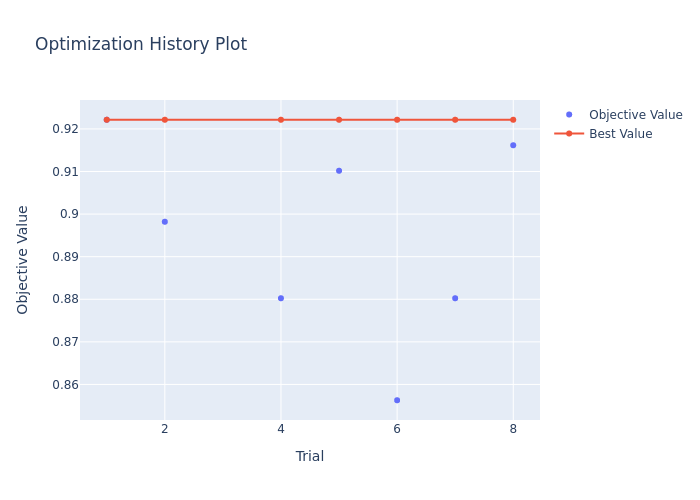

In [11]:
opt_hist = optuna.visualization.plot_optimization_history(study)

opt_hist_image_bytes = opt_hist.to_image(format="png")

Image(opt_hist_image_bytes)

## Inference on Test Set

In [ ]:
best_model_data = os.path.join(
    tf_estimator.output_path,
    study.best_trial.user_attrs["job_name"],
    "output/model.tar.gz",
)

best_model = TensorFlowModel(
    model_data=best_model_data, role=role, framework_version=FRAMEWORK_VERSION
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.2xlarge",
    endpoint_name=endpoint_name + "-v1",
    container_startup_health_check_timeout=5 * 60,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2023-05-06-13-38-08-528
INFO:sagemaker:Creating endpoint-config with name weather-classification-cnn-2023-05-06-v1
INFO:sagemaker:Creating endpoint with name weather-classification-cnn-2023-05-06-v1


---!

 Read in test data:

In [58]:
# Load test data
X_test = np.load(
    io.BytesIO(
        s3.get_object(Bucket=s3_bucket, Key=f"{s3_key}/input-data/test/X_test.npy")[
            "Body"
        ].read()
    )
)
y_test = np.load(
    io.BytesIO(
        s3.get_object(Bucket=s3_bucket, Key=f"{s3_key}/input-data/test/y_test.npy")[
            "Body"
        ].read()
    )
)

X_test.shape, y_test.shape

((172, 256, 256, 3), (172,))

Make predictions in batches:

In [66]:
# Define the batch size
batch_size = 5

# Generate predictions in batches
num_instances = X_test.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

predicted_labels = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = X_test[start_idx:end_idx]

    # Call the predict method of the TensorFlowPredictor object
    predictions = predictor.predict(batch)

    # Extract the predicted labels from the response
    predicted_labels_batch = np.argmax(
        predictions["predictions"], axis=1
    )  # Use axis=1 to find max probability across 4 columns (classes)

    # Append the predicted labels to the list
    predicted_labels.append(predicted_labels_batch)

# Concatenate the predicted labels from all batches
predicted_labels = np.concatenate(predicted_labels, axis=0)

predicted_labels

100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


array([0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3])

Accuracy score on test set:

In [69]:
print(
    "Accuracy score on test set:",
    accuracy_score(y_true=y_test, y_pred=predicted_labels),
)

Accuracy score on test set: 0.936046511627907


## Clean Up

In [ ]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

In [ ]:
sm_boto3.close()